# Can sentiment be a good predictor of how the Dow Jones will do that day

### 1.1 Import libaries

In [2]:
import os
import re
import time

import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt


import nltk
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from nltk.stem.porter import *

from bs4 import BeautifulSoup
from wordcloud import WordCloud
import pickle

from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, EditedNearestNeighbours 
from imblearn.under_sampling import AllKNN, NearMiss, OneSidedSelection, TomekLinks
from imblearn.metrics import classification_report_imbalanced

from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


### 1.2 Retrieve Data

In [3]:
data = pd.read_csv('./data/Combined_News_DJIA.csv', encoding='utf-8')

In [4]:
data.head()
data.shape

(1989, 27)

In [5]:
#Remove byte String, newline tabs and the rest
data = data.replace({"b'": "", 'b"': '', '\n': '', '\t': ''}, regex=True)
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash',"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,"No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,"Olympic opening ceremony fireworks 'faked'""",What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,...,Israel and the US behind the Georgian aggressi...,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...
2,2008-08-12,0,Remember that adorable 9-year-old who sang at ...,"Russia 'ends Georgia operation'""","""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the W...,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right',"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two'",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?',BBC NEWS | Asia-Pacific | Extinction 'by man n...
3,2008-08-13,0,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,"Britain\'s policy of being tough on drugs is ""...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,Bush announces Operation Get All Up In Russia'...,Russian forces sink Georgian ships ',...,Elephants extinct by 2020?',US humanitarian missions soon in Georgia - if ...,"Georgia's DDOS came from US sources""","Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice',Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: ...,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...
4,2008-08-14,1,All the experts admit that we should legalise ...,War in South Osetia - 89 pictures made by a Ru...,Swedish wrestler Ara Abrahamian throws away me...,Russia exaggerated the death toll in South Oss...,Missile That Killed 9 Inside Pakistan May Have...,Rushdie Condemns Random House's Refusal to Pub...,Poland and US agree to missle defense deal. In...,"Will the Russians conquer Tblisi? Bet on it,

In [6]:
clean_df = data.iloc[:,0:2] 
clean_df['Combined'] = data.iloc[:,2:].apply(lambda row: ''.join(str(row.values)), axis=1)
clean_df['Combined'] = clean_df['Combined'].replace('[^a-zA-Z ]', '', regex=True)
#clean_df['Combined'] = clean_df['Combined'].replace('[^a-zA-Z ]', '', regex=True)
clean_df.tail()

,Date,Label,Combined
1984,2016-06-27,0,Barclays and RBS shares suspended from trading...
1985,2016-06-28,1,Scientists To Australia If You Want To Save T...
1986,2016-06-29,1,Explosion At Airport In Istanbul Yemeni former...
1987,2016-06-30,1,Jamaica proposes marijuana dispensers for tour...
1988,2016-07-01,1,A yearold woman in Mexico City finally receive...


In [7]:
# Only evaluate data from 1/4/2010-7/1/2016
clean_df = clean_df[clean_df['Date'] >= '2010-01-04']

In [8]:
X = clean_df.iloc[:,[0,2]]
y = clean_df.iloc[:,[0,1]]
print(X.shape, y.shape)

(1636, 2) (1636, 2)


### 1.3 Clean Data.  Remove bytes and consolidate news articles.  Thanks to Kate for consolidation logic

In [9]:
X.head()

,Date,Combined
353,2010-01-04,New airport scanners break child porn laws Ind...
354,2010-01-05,These images depict the untouched stomach cont...
355,2010-01-06,Three Americans go to Uganda and teach thousan...
356,2010-01-07,yearold British woman on holiday in Dubai told...
357,2010-01-08,Top Imams affiliated with the Islamic Supreme ...


## 1.4 Benchmark test
Run a benchmark test using the existing label.  Do a time based split based on 70/30 ratio training to test set.  Utilize TF-IDF and XGBoost

In [10]:
ddates = X['Date'].unique()
cutoff = ddates[int(len(ddates)*.7)]
X_split_train = X[X['Date'] <= cutoff]
y_split_train = y[y['Date'] <= cutoff]['Label']
X_split_test = X[X['Date'] > cutoff]
y_split_test = y[y['Date'] > cutoff]['Label']

In [12]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

label = 'Split'
model = XGBClassifier()
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(1,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)

# Get TF-IDF on all the data
train_features = tv.fit_transform(X_split_train['Combined'].dropna().values.flatten())
test_features = tv.transform(X_split_test['Combined'].dropna().values.flatten())


# Run modeling algorithm
model = model.fit(train_features.toarray(), y_split_train)
predictions = model.predict(test_features.toarray())

accuracy = accuracy_score(y_split_test, predictions)
precision = precision_score(y_split_test, predictions, labels=[-1,1], average='weighted')
recall = recall_score(y_split_test, predictions, labels=[-1,1], average='weighted')
f1 = f1_score(y_split_test, predictions, labels=[-1,1], average='weighted')
cohen = cohen_kappa_score(y_split_test, predictions, labels=[-1,1])
score = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Cappa': cohen}
score_df = score_df.append(score, ignore_index=True)

In [13]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,NaN,0.559184,0.554896,0.73913,0.633898,NaN


### 1.4 Utilize 1 and 2 sigma classification for stocks

#### 1.4.1 Import stock data

In [9]:
stockdf = pd.read_csv('./data/DJIA_table.csv', encoding='utf-8')

In [10]:
stockdf.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


#### 1.4.2 Calculate Daily return which is difference between open and close

In [11]:
stockdf['Daily Return']=(stockdf['Close']-stockdf['Open'])/stockdf['Open']*100
stockdf.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Daily Return
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,0.140195
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,1.226407
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,1.367208
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,1.275186
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-1.238652


#### 1.4.3 Generate sigma (std dev) based on stock change by day

In [12]:
sigma = stockdf['Daily Return'].agg({'mean', 'std'})
sigma

std     1.252473
mean    0.036604
Name: Daily Return, dtype: float64

In [13]:
sigma['1sigmalow']=sigma['mean']-sigma['std']
sigma['1sigmahi']=sigma['mean']+sigma['std']
sigma['2sigmalow']=sigma['mean']-2*(sigma['std'])
sigma['2sigmahi']=sigma['mean']+2*(sigma['std'])
sigma

std          1.252473
mean         0.036604
1sigmalow   -1.215870
1sigmahi     1.289077
2sigmalow   -2.468343
2sigmahi     2.541550
Name: Daily Return, dtype: float64

#### 1.4.4 Classify stocks by std dev away

In [14]:
def onesigma(row):
    if row['Daily Return'] < sigma['1sigmalow']:
        row['Label1Sig'] = -1
    elif row['Daily Return'] > sigma['1sigmahi']:
        row['Label1Sig'] = 1
    else:
        row['Label1Sig'] = 0
    if row['Daily Return'] < sigma['2sigmalow']:
        row['Label2Sig'] = -1
    elif row['Daily Return'] > sigma['2sigmahi']:
        row['Label2Sig'] = 1
    else:
        row['Label2Sig'] = 0
    return row

In [15]:
stockdf['Label1Sig'] = 0
stockdf['Label2Sig'] = 0

In [16]:
labled_df = stockdf.apply(onesigma, axis=1)
labled_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close,Daily Return,Label1Sig,Label2Sig
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,0.140195,0,0
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,1.226407,0,0
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,1.367208,1,0
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,1.275186,0,0
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,-1.238652,-1,0


#### 1.4.5 Visual the classification 1 and 2 sigma (std dev) away.

In [17]:
classifier_df = pd.DataFrame(columns=['HOLD', 'BUY', 'SELL', 'TOTAL'], index=['1 sigma', '2 sigma'],
                            data=[[len(labled_df[labled_df['Label1Sig'] == 0]),len(labled_df[labled_df['Label1Sig'] == 1]),len(labled_df[labled_df['Label1Sig'] == -1]),len(labled_df)],
                                 [len(labled_df[labled_df['Label2Sig'] == 0]),len(labled_df[labled_df['Label2Sig'] == 1]),len(labled_df[labled_df['Label2Sig'] == -1]),len(labled_df)]])
classifier_df['HOLD_PCT'] = classifier_df['HOLD']/classifier_df['TOTAL']*100
classifier_df['BUY_PCT'] = classifier_df['BUY']/classifier_df['TOTAL']*100
classifier_df['SELL_PCT'] = classifier_df['SELL']/classifier_df['TOTAL']*100
classifier_df

,HOLD,BUY,SELL,TOTAL,HOLD_PCT,BUY_PCT,SELL_PCT
1 sigma,1613,179,197,1989,81.096028,8.999497,9.904475
2 sigma,1890,45,54,1989,95.022624,2.262443,2.714932


### 1.5 Merge the News and stock data sets

In [18]:
merge_df = pd.merge(clean_df, labled_df[['Date','Daily Return', 'Label1Sig', 'Label2Sig']], on='Date')
merge_df.head()

,Date,Label,Combined,Daily Return,Label1Sig,Label2Sig
0,2010-01-04,1,New airport scanners break child porn laws Ind...,1.469409,1,0
1,2010-01-05,0,These images depict the untouched stomach cont...,-0.118475,0,0
2,2010-01-06,1,Three Americans go to Uganda and teach thousan...,0.084810,0,0
3,2010-01-07,1,yearold British woman on holiday in Dubai told...,0.338186,0,0
4,2010-01-08,1,Top Imams affiliated with the Islamic Supreme ...,0.111160,0,0


### 1.6 Build Word cloud for negative articles

In [19]:
neg_words = []
neg_phrases = merge_df[merge_df['Label1Sig'] == -1]['Combined'].values
for phrase in neg_phrases:
    for word in phrase.split():
        neg_words.append(word)
neg_words[:5]

['Im', 'proud', 'the', 'Dutch', 'collect']

In [20]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'Im proud the Dutch collect over mln for Haiti government doubles it all totaling Dutch link A TSA wo'

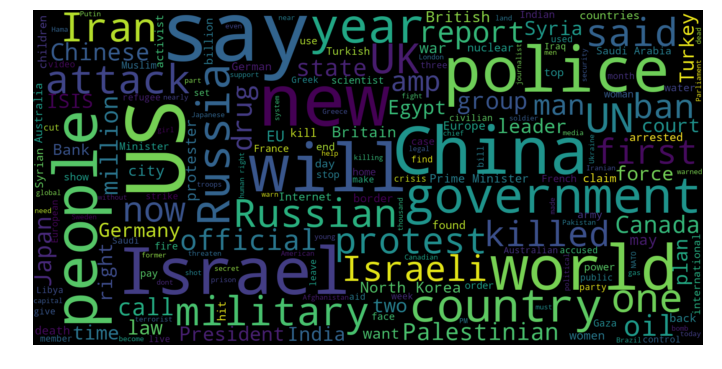

In [21]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
pos_words = []
pos_phrases = merge_df[merge_df['Label1Sig'] == 1]['Combined'].values
for phrase in pos_phrases:
    for word in phrase.split():
        pos_words.append(word)
pos_words[:5]

['New', 'airport', 'scanners', 'break', 'child']

In [23]:
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:100]

'New airport scanners break child porn laws Indian eye clinic founded by a single doc has treated mil'

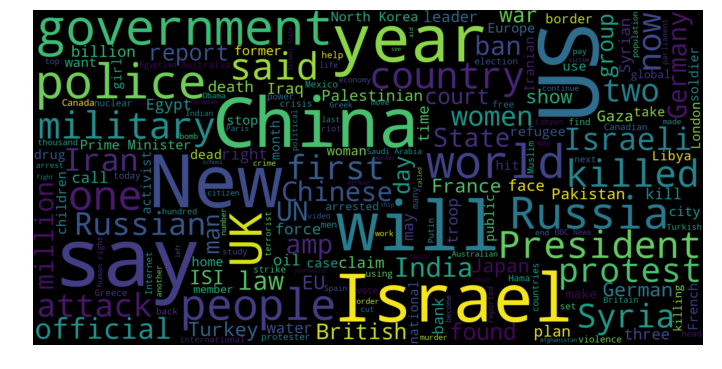

In [24]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 1.6 Separate train and test Data

In [25]:
sigma = 'Label1Sig'
X = merge_df[['Date', sigma,'Combined']]
X = X.set_index('Date')
y = merge_df[sigma]
X.head()

,Label1Sig,Combined
Date,,
2010-01-04,1,New airport scanners break child porn laws Ind...
2010-01-05,0,These images depict the untouched stomach cont...
2010-01-06,0,Three Americans go to Uganda and teach thousan...
2010-01-07,0,yearold British woman on holiday in Dubai told...
2010-01-08,0,Top Imams affiliated with the Islamic Supreme ...


### 1.6.1 Split data first by time series

In [26]:
train_arr = []
test_arr = []
tscv = TimeSeriesSplit(n_splits=7)
for train_index, test_index in tscv.split(X):
    train_arr.append(train_index)
    test_arr.append(test_index)

In [27]:
def get_train_test_val_split(train_index, test_index):
    test_size = min(int(len(train_index)/2), len(test_index))
    X_train, X_val, X_test = X.iloc[train_index[0:-test_size-1],:], X.iloc[train_index[-test_size:],:], X.iloc[test_index,:]
    y_train, y_val, y_test = y[train_index[0:-test_size-1]],y[train_index[-test_size:]], y[test_index]
    return X_train, X_val, X_test, y_train, y_val, y_test

In [28]:
train_index = train_arr[6]
test_index = test_arr[6]
test_size = len(test_arr[6])
print(test_size)
print('train',train_index[0],train_index[-test_size-1])
print('valid',train_index[-test_size],train_index[-1])
print('test',test_index[0],test_index[-1])

204
train 0 1227
valid 1228 1431
test 1432 1635


#### Initiallly test the types of undersampling and models based on data and then perform the time split

In [29]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_val_split(train_arr[6], test_arr[6])
X_train.tail()

,Label1Sig,Combined
Date,,
2014-11-10,0,Pope Francis has excommunicated a pedophile Ar...
2014-11-11,0,Geologists who didnt predict an earthquake are...
2014-11-12,0,Russian combat troops have entered Ukraine alo...
2014-11-13,0,European robot probe Philae has made the first...
2014-11-14,0,Sweden has proof foreign sub entered its water...


#### 1.6.2 Run bag of words and term frequency on training set

In [30]:
cv = CountVectorizer(stop_words='english', ngram_range=(1,3), max_features=10000, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
tv = TfidfVectorizer(analyzer='word',min_df=0.0, max_df=1.0, ngram_range=(1,3), token_pattern=r'\w{1,}', sublinear_tf=True, max_features=10000)

# Lowers all words and removes any numbers from terms
# def get_bag_of_words(cv, X):
#     train_features = cv.fit_transform(X['Combined'])
#     return train_features

# def get_term_freq(tv, X):
#     train_features = tv.fit_transform(X['Combined'].dropna().values.flatten())
#     return train_features

def display_term_count(X, y):
    neg_matrix=cv.transform(X.iloc[np.where(y == -1)[0].tolist(), :].Combined)
    neg_words = neg_matrix.sum(axis=0)
    neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])
    neg_tf = neg_tf.set_index('Terms')

    pos_matrix=cv.transform(X.iloc[np.where(y == 1)[0].tolist(), :].Combined)
    pos_words = pos_matrix.sum(axis=0)
    pos_words_freq = [(word,pos_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    pos_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
    pos_tf = pos_tf.set_index('Terms')

    term_df = pd.concat([neg_tf, pos_tf], sort=True, axis=1)
    term_df['total'] = term_df['negative']+term_df['positive']
    term_df = term_df.sort_values(by='total', ascending=False)
    print(term_df.head(5))
    
def score_test(name, y_test, y_predict):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, labels=[-1,1], average='weighted')
    recall = recall_score(y_test, predictions, labels=[-1,1], average='weighted')
    f1 = f1_score(y_test, predictions, labels=[-1,1], average='weighted')
    cohen = cohen_kappa_score(y_test, predictions, labels=[-1,1])
    return {'Name': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Cappa': cohen}

def calc_true_score(label, y_test, y_predict):
    conf_matrix = pd.crosstab(y_test, y_predict, rownames=["Actual"], colnames=["Predicted"])
    if conf_matrix.shape[0] < 3 | conf_matrix.shape[1] < 3:
        return   # if predictions are all 1 value then do not print
        
    conf_arr = [
        {
            'Label': label, 'Good/Bad': 'Good',
            'Buy': conf_matrix.get(1,{}).get(1,0),
            'Sell': conf_matrix.get(-1,{}).get(-1,0),
            'Hold': conf_matrix.get(0,{}).get(0,0),
            'Miss': 0,
            'Total': conf_matrix.get(1,{}).get(1,0)+conf_matrix.get(-1,{}).get(-1,0)+conf_matrix.get(0,{}).get(0,0)
        },
        {
            'Label': label, 'Good/Bad': 'Bad',
            'Buy': conf_matrix.get(1,{}).get(-1,0),
            'Sell': conf_matrix.get(-1,{}).get(1,0),
            'Hold': conf_matrix.get(0,{}).get(1,0)+conf_matrix.get(0,{}).get(-1,0),
            'Miss': conf_matrix.get(1,{}).get(0,0)+conf_matrix.get(-1,{}).get(0,0),
            'Total': conf_matrix.iloc[1,:].sum()
        }
    ]
    conf_arr.append({'Label': label+' Total', 'Good/Bad': '',
                    'Buy': conf_arr[0]['Buy'] + conf_arr[1]['Buy'],
                    'Sell': conf_arr[0]['Sell'] + conf_arr[1]['Sell'],
                    'Hold': conf_arr[0]['Hold'] + conf_arr[1]['Hold'],
                    'Miss': conf_arr[0]['Miss'] + conf_arr[1]['Miss'],
                    'Total': conf_arr[0]['Total'] + conf_arr[1]['Total']
                    })
    conf_arr.append({'Label': label+' %', 'Good/Bad': 'True%',
                    'Buy': round(100*conf_arr[0]['Buy'] / conf_arr[2]['Buy'] if conf_arr[2]['Buy'] else 0),
                    'Sell': round(100*conf_arr[0]['Sell'] / conf_arr[2]['Sell'] if conf_arr[2]['Sell'] else 0),
                    'Hold': round(100*conf_arr[0]['Hold'] / conf_arr[2]['Hold'] if conf_arr[2]['Hold'] else 0),
                    'Miss': round(100*conf_arr[1]['Miss'] / conf_arr[2]['Hold'] if conf_arr[2]['Hold'] else 0),
                    'Total': round(100*conf_arr[0]['Total'] / conf_arr[2]['Total'])
                    })
    return conf_arr


In [31]:
cv.fit(X['Combined'])
cv_train_features = cv.transform(X['Combined'])
cv_train_df = pd.DataFrame(cv_train_features.toarray(), columns=list(cv.get_feature_names()))
cv_train_df.shape

(1636, 10000)

In [32]:
tv.fit(X['Combined'].dropna().values.flatten())
tv_train_features = tv.transform(X_train['Combined'].dropna().values.flatten())

tv_train_df = pd.DataFrame(tv_train_features.toarray(), columns=list(tv.get_feature_names()))
tv_train_df.shape

(1227, 10000)

In [33]:
display_term_count(X_train, y_train)

        negative  positive  total
new           98       103    201
israel        99       101    200
police       104        96    200
says          95        87    182
china         80        98    178


### 1.7 Run undersampling on the BOW and TF-IDF

#### 1.7.1 Undersampling methods

In [34]:
rnd = RandomUnderSampler(sampling_strategy='majority')
X_sampled, y_sampled = rnd.fit_sample(tv_train_features, y_train)

In [35]:
print(len(np.where(y_sampled == -1)[0]))
print(len(np.where(y_sampled == 0)[0]))
print(len(np.where(y_sampled == 1)[0]))


84
80
80


In [36]:
sampled_df = pd.DataFrame(X_sampled.toarray(), columns=list(tv.get_feature_names()))
sampled_df.head()

,a,a ban,a ban on,a barrel,a better,a bid,a bid to,a big,a bill,a billion,...,zealands,zero,zetas,zika,zika virus,zimbabwe,zimbabwes,zone,zones,zoo
0,0.040581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.035174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.037232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.043355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.042192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046705,0.0,0.0


In [37]:
max(len(y_test[y_test == 1]),len(y_test[y_test == -1]))*2

40

In [38]:
model = LogisticRegression(solver='liblinear', multi_class='auto')
model = model.fit(sampled_df, y_sampled)

In [39]:
test_features = tv.transform(X_test['Combined'])
predictions = model.predict(test_features)

In [40]:
score = score_test('ALL', y_test, predictions)
print(score)

{'Name': 'ALL', 'Accuracy': 0.3382352941176471, 'Precision': 0.10086191087474784, 'Recall': 0.4, 'F1': 0.14632426397132278, 'Cappa': 0.0}


In [41]:
pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,-1,0,1
Actual,,,
-1,12,6,2
0,99,55,15
1,12,1,2


In [42]:
calc_true_score('ALL', y_test, predictions)

[{'Label': 'ALL',
  'Good/Bad': 'Good',
  'Buy': 2,
  'Sell': 12,
  'Hold': 55,
  'Miss': 0,
  'Total': 69},
 {'Label': 'ALL',
  'Good/Bad': 'Bad',
  'Buy': 2,
  'Sell': 12,
  'Hold': 7,
  'Miss': 114,
  'Total': 169},
 {'Label': 'ALL Total',
  'Good/Bad': '',
  'Buy': 4,
  'Sell': 24,
  'Hold': 62,
  'Miss': 114,
  'Total': 238},
 {'Label': 'ALL %',
  'Good/Bad': 'True%',
  'Buy': 50.0,
  'Sell': 50.0,
  'Hold': 89.0,
  'Miss': 184.0,
  'Total': 29.0}]

### 1.7.2 Run against all data first

In [43]:
vector = tv
model = LogisticRegression(solver='liblinear', multi_class='auto')
# cv_train_features = get_bag_of_words(cv, X_train)
vector.fit(X['Combined'].dropna().values.flatten())
train_features = vector.transform(X_train['Combined'].dropna().values.flatten())
train_df = pd.DataFrame(train_features.toarray(), columns=list(vector.get_feature_names()))
model = model.fit(train_df, y_train)
print(train_df.shape)
train_df.head()

(1227, 10000)


,a,a ban,a ban on,a barrel,a better,a bid,a bid to,a big,a bill,a billion,...,zealands,zero,zetas,zika,zika virus,zimbabwe,zimbabwes,zone,zones,zoo
0,0.042284,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.036619,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.041837,0.0,0.0,0.0,0.0,0.0,0.0,0.058853,0.057116,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.042528,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.045286,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
test_features = vector.transform(X_test['Combined'].dropna().values.flatten())
predictions = model.predict(test_features)

In [45]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])
score = score_test('ALL', y_test, predictions)
score_df = score_df.append(score , ignore_index=True)
conf_df = conf_df.append(calc_true_score('ALL', y_test, predictions))
score_df

C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:561: RuntimeWarning: invalid value encountered in true_divide
  expected = np.outer(sum0, sum1) / np.sum(sum0)


,Name,Accuracy,Precision,Recall,F1,Cappa
0,ALL,0.828431,0.0,0.0,0.0,NaN


In [46]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,ALL %,True%,0,0,83.0,0.0,50.0


#### 1.7.2 Define sampler method that will be used to compare samplers

In [47]:
# only sample majority
sampling_strategy='majority'

samplers = []
# samplers.append(('ENN', EditedNearestNeighbours(sampling_strategy))) 
# samplers.append(('KNN', AllKNN(sampling_strategy))) 
# samplers.append(('OneSide', OneSidedSelection(sampling_strategy))) 
# samplers.append(('Tomek', TomekLinks(sampling_strategy))) 
samplers.append(('Miss', NearMiss(sampling_strategy))) 
samplers.append(('RND', RandomUnderSampler(sampling_strategy))) 
samplers.append(('CC', ClusterCentroids(sampling_strategy))) 

#### First run against entire dataset and then compare against undersampling algorithms

#### Run undersampling algorithms

In [48]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

test_features = vector.transform(X_test['Combined'].dropna().values.flatten())
for name, sampler in samplers:
    X_sampled, y_sampled = sampler.fit_sample(train_features, y_train)
    model = model.fit(X_sampled.toarray(), y_sampled)
    predictions = model.predict(test_features)
    score = score_test(name, y_test, predictions)
    score_df = score_df.append(score , ignore_index=True)
    conf_df = conf_df.append(calc_true_score(name, y_test, predictions))

In [49]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,Miss,0.112745,0.096957,0.542857,0.153893,0.044944
1,RND,0.534314,0.067227,0.228571,0.103896,-0.226415
2,CC,0.416667,0.127799,0.428571,0.182927,0.107143


In [50]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,Miss %,True%,50.0,57.0,80.0,3300.0,12.0
3,RND %,True%,0.0,73.0,82.0,55.0,39.0
3,CC %,True%,50.0,63.0,88.0,124.0,33.0


#### Random and Cluster Centroid both had similar values but getting random values had a better precision value.  NearMiss was lower in accuracy but was better at being precise.  Could use Near Miss or random but at this point there is no stark difference in the undersampling algorithms

## 1.8 Analyze Model Algorithms for Baseline

#### Utilize random undersampling and then focus on model algorithms

In [51]:
tv.fit(X['Combined'].dropna().values.flatten())
train_features = tv.transform(X_train['Combined'].dropna().values.flatten())
test_features = tv.transform(X_test['Combined'].dropna().values.flatten())
train_features.shape

(1227, 10000)

In [52]:
sampler = RandomUnderSampler(sampling_strategy='majority')
X_sampled, y_sampled = sampler.fit_sample(train_features, y_train)

In [53]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='auto')))
models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('LDA-s', LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')))
# models.append(('KNN', NeighborhoodComponentsAnalysis())) # out of memory
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', MultinomialNB()))
models.append(('LGB', LGBMClassifier()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100, max_depth=2)))

In [54]:
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

for name, model in models:
    print(name)
    model = model.fit(X_sampled.toarray(), y_sampled)
    predictions = model.predict(test_features.toarray())
    
    score = score_test(name, y_test, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(calc_true_score(name, y_test, predictions))

LR
LDA


C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


CART
NB
LGB
SVC
RFC


C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,LR,0.421569,0.131755,0.428571,0.183617,0.000000
1,LDA,0.357843,0.106732,0.400000,0.152788,0.062500
2,CART,0.328431,0.072118,0.257143,0.111355,-0.125984
3,NB,0.245098,0.113912,0.542857,0.165875,0.054545
4,LGB,0.387255,0.090188,0.314286,0.140113,0.173913
5,SVC,0.098039,0.056022,0.571429,0.102041,0.000000
6,RFC,0.460784,0.100186,0.314286,0.145233,0.100000


In [56]:
model = XGBClassifier(max_depth=3,objective='multi:softmax', num_class=100,n_gpus=0)
model = model.fit(X_sampled.tocsc(), y_sampled)
predictions = model.predict(test_features.tocsc())

score = score_test('XGB', y_test, predictions)
score_df = score_df.append(score, ignore_index=True)
conf_df = conf_df.append(calc_true_score('XGB', y_test, predictions))

In [57]:
score_df.sort_values(by=['Cappa'])

,Name,Accuracy,Precision,Recall,F1,Cappa
2,CART,0.328431,0.072118,0.257143,0.111355,-0.125984
7,XGB,0.367647,0.094131,0.342857,0.146900,-0.006192
0,LR,0.421569,0.131755,0.428571,0.183617,0.000000
5,SVC,0.098039,0.056022,0.571429,0.102041,0.000000
3,NB,0.245098,0.113912,0.542857,0.165875,0.054545
1,LDA,0.357843,0.106732,0.400000,0.152788,0.062500
6,RFC,0.460784,0.100186,0.314286,0.145233,0.100000
4,LGB,0.387255,0.090188,0.314286,0.140113,0.173913


In [58]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,LR %,True%,43.0,57.0,91.0,126.0,34.0
3,LDA %,True%,50.0,60.0,84.0,157.0,30.0
3,CART %,True%,31.0,56.0,82.0,156.0,28.0
3,NB %,True%,50.0,61.0,91.0,406.0,23.0
3,LGB %,True%,54.0,67.0,81.0,120.0,32.0
3,SVC %,True%,0.0,57.0,0.0,0.0,11.0
3,RFC %,True%,67.0,53.0,85.0,88.0,36.0
3,XGB %,True%,36.0,64.0,86.0,145.0,31.0


## 1.8.2 Model Selection

#### It looks like the decision tree classifier and the Extreme Gradient Boost had the best Cappa scores.  The accuracy and precision were much higher than the other classifiers.

Will now use the time series to analyze it based on the decion tree classifier

# 1.9 Time Series split and print

In [59]:
def train_model(model, name, train_x, train_y, test_x):
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    score = score_test(name, train_y, predictions)
    return score

In [60]:
# Setup for further tuning
model = DecisionTreeClassifier()

### 1.9.1 Split the data

In [61]:
train_arr = []
test_arr = []
tscv = TimeSeriesSplit(n_splits=7)
sampler = RandomUnderSampler(sampling_strategy='majority')
model = DecisionTreeClassifier()

In [62]:
name='DT'
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])

tv.fit(X['Combined'].dropna().values.flatten())
for train_index, test_index in tscv.split(X):
    # Split data by train, validation and test.  Use the validation step to tune
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_val_split(train_index, test_index)
    
    # Get TF-IDF on all the data
    train_features = tv.transform(X_train['Combined'].dropna().values.flatten())
    val_features = tv.transform(X_val['Combined'].dropna().values.flatten())
    test_features = tv.transform(X_test['Combined'].dropna().values.flatten())
    
    # Run undersampling algorithm
    X_sampled, y_sampled = sampler.fit_sample(train_features, y_train)
    
    # Run modeling algorithm
    model = model.fit(X_sampled.toarray(), y_sampled)
    predictions = model.predict(val_features.toarray())
    
    # Aggregate scores
    score = score_test(name+str(train_index[-1]), y_val, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(calc_true_score(name+str(train_index[-1]), y_val, predictions))

In [63]:
name='Test'
# Run modeling algorithm
predictions = model.predict(test_features.toarray())

# Aggregate scores
score = score_test(name, y_test, predictions)
score_df = score_df.append(score, ignore_index=True)
conf_df = conf_df.append(calc_true_score(name, y_test, predictions))

In [64]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,DT207,0.298077,0.094385,0.318182,0.145582,-0.125000
1,DT411,0.504902,0.087250,0.266667,0.130896,0.269663
2,DT615,0.284314,0.073790,0.188679,0.103235,-0.409639
3,DT819,0.372549,0.067187,0.375000,0.112888,-0.125000
4,DT1023,0.313725,0.038695,0.454545,0.070769,0.100000
5,DT1227,0.308824,0.058840,0.461538,0.103568,0.384615
6,DT1431,0.397059,0.104216,0.406250,0.165858,0.243243
7,Test,0.362745,0.110899,0.400000,0.169388,0.290323


In [65]:
score_df.iloc[:,1:].agg(['sum', 'mean'])

,Accuracy,Precision,Recall,F1,Cappa
sum,2.842195,0.635262,2.870862,1.002183,0.628206
mean,0.355274,0.079408,0.358858,0.125273,0.078526


In [66]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,DT207 %,True%,43.0,44.0,80.0,193.0,27.0
3,DT411 %,True%,50.0,80.0,85.0,71.0,37.0
3,DT615 %,True%,29.0,27.0,74.0,158.0,28.0
3,DT819 %,True%,62.0,25.0,95.0,159.0,29.0
3,DT1023 %,True%,50.0,60.0,97.0,220.0,25.0
3,DT1227 %,True%,33.0,100.0,92.0,216.0,25.0
3,DT1431 %,True%,55.0,70.0,86.0,132.0,32.0
3,Test %,True%,57.0,75.0,82.0,149.0,30.0


#### Analysis: Precision is very minimal

In observing the data the True Positive is inaccurate and the classifier is unable to truly separate the data.  The undersampling resulted in too much data being classified as buy or sell.

### 1.9.2 Run data without undersampling

In [67]:
name='DT'
score_df = pd.DataFrame(columns=['Name', 'Accuracy','Precision','Recall','F1','Cappa'])
conf_df = pd.DataFrame(columns=['Label', 'Good/Bad','Buy','Sell','Hold','Miss','Total'])
tv.fit(X['Combined'].dropna().values.flatten())
for train_index, test_index in tscv.split(X):
    # Split data by train, validation and test.  Use the validation step to tune
    X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_val_split(train_index, test_index)
    
    # Get TF-IDF on all the data
    train_features = tv.transform(X_train['Combined'].dropna().values.flatten())
    val_features = tv.transform(X_val['Combined'].dropna().values.flatten())
    test_features = tv.transform(X_test['Combined'].dropna().values.flatten())
    
  
    # Run modeling algorithm
    model = model.fit(train_features.toarray(), y_train)
    predictions = model.predict(val_features.toarray())
    
    # Aggregate scores
    score = score_test(name+str(train_index[-1]), y_val, predictions)
    score_df = score_df.append(score, ignore_index=True)
    conf_df = conf_df.append(calc_true_score(name+str(train_index[-1]), y_val, predictions))

C:\Users\salfl\.conda\envs\ml\lib\site-packages\sklearn\metrics\classification.py:576: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [68]:
name='Test'
# Run modeling algorithm
predictions = model.predict(test_features.toarray())

# Aggregate scores
score = score_test(name, y_test, predictions)
score_df = score_df.append(score, ignore_index=True)

In [69]:
score_df

,Name,Accuracy,Precision,Recall,F1,Cappa
0,DT207,0.711538,0.050505,0.045455,0.047847,-0.500000
1,DT411,0.696078,0.045333,0.066667,0.053968,-0.363636
2,DT615,0.627451,0.193396,0.150943,0.150828,-0.181818
3,DT819,0.759804,0.069062,0.187500,0.096464,0.166667
4,DT1023,0.794118,0.048951,0.090909,0.063636,NaN
5,DT1227,0.867647,0.069231,0.076923,0.072874,0.000000
6,DT1431,0.715686,0.070312,0.062500,0.066176,0.000000
7,Test,0.725490,0.060150,0.057143,0.058608,0.000000


In [70]:
score_df.iloc[:,1:].agg(['sum', 'mean'])

,Accuracy,Precision,Recall,F1,Cappa
sum,5.897813,0.606942,0.738040,0.610403,-0.878788
mean,0.737227,0.075868,0.092255,0.076300,-0.125541


#### Adding\removing undersampling did not make any definable change in the data

In [71]:
conf_df[conf_df['Good/Bad'] == 'True%']

,Label,Good/Bad,Buy,Sell,Hold,Miss,Total
3,DT207 %,True%,0.0,33.0,80.0,10.0,47.0
3,DT411 %,True%,0.0,50.0,85.0,21.0,45.0
3,DT615 %,True%,43.0,36.0,79.0,20.0,46.0
3,DT819 %,True%,50.0,67.0,93.0,22.0,45.0
3,DT1023 %,True%,0.0,100.0,94.0,19.0,46.0
3,DT1227 %,True%,0.0,100.0,94.0,8.0,48.0
3,DT1431 %,True%,0.0,100.0,83.0,16.0,46.0
